## Stock selection according to Hossein PTS Cointegration 
- we calculate the spread between the normalized prices of all possible combinations of stock pairs during the formation period. The formation period is chosen to be 12 months. 
- The normalized price is defined as the cumulative return index, adjusted for dividends and other corporate actions, and scaled to $1 at the beginning of the formation period. In the trading period, this price is used to calculate the spread. 
- We then select 20 of those combinations that have the least sum of squared spreads, or sum of squared differences (SSD), to form the nominated pairs to trade in the following trading period, that is chosen to be 6 months. The standard deviation of the spread during the formation period is also recorded and used as the trading criterion. A specific stock can participate in forming more than one pair as long as the other stock of the pair varies.
- then we test each of the pairs with the least SSD for cointegration,
by using their cumulative return series in the formation period. Pairs that are not cointegrated are eliminated in the selection process. Pairs that are cointegrated will have their cointegration coefficient estimated. We continue until 20 cointegrated pairs with minimum SSDs are selected to be traded in the following trading period
- After selecting nominated cointegrated pairs using the two-step Engle-Granger method (Engle and Granger, 1987), we extract their stationary spread.
- Thus, the profit of buying one share of stock 2 and selling beta share of stock 1 for the period delta t is given by the change in the spread for that period.

In [ ]:
import pandas as pd 
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import warnings
import math 
from tqdm import tqdm
import matplotlib.pyplot as plt
from itertools import combinations
from cointegration_functions import * 



# Before Costs 

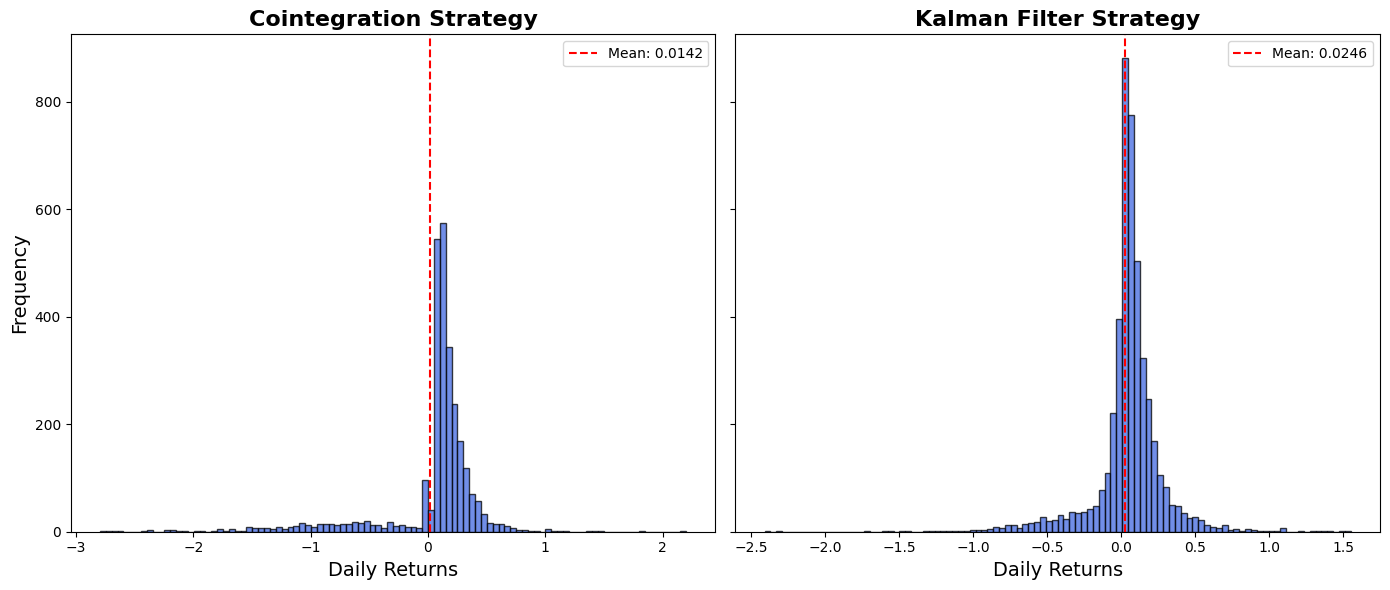

204.082561429031


In [56]:
# Load cointegration strategy returns
backtest_cointegration_returns = pd.read_csv("./results/backtest_cointegration_returns_nocost.csv", index_col=0)
daily_returns_coint = pd.DataFrame(backtest_cointegration_returns).sum(axis=1)
daily_returns_hist_coint = daily_returns_coint[daily_returns_coint != 0]

# Load Kalman strategy returns
backtest_kalman_returns = pd.read_csv("./results/backtest_kalman_returns_nocost.csv", index_col=0)
daily_returns_kalm = pd.DataFrame(backtest_kalman_returns).sum(axis=1)
daily_returns_hist_kalm = daily_returns_kalm[daily_returns_kalm != 0]

# Plot side-by-side histograms
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Cointegration histogram
axes[0].hist(daily_returns_hist_coint, bins=100, color="royalblue", edgecolor="black", alpha=0.75)
axes[0].axvline(daily_returns_coint.mean(), color='red', linestyle='dashed', linewidth=1.5,
                label=f"Mean: {daily_returns_coint.mean():.4f}")
axes[0].set_title("Cointegration Strategy", fontsize=16, fontweight="bold")
axes[0].set_xlabel("Daily Returns", fontsize=14)
axes[0].set_ylabel("Frequency", fontsize=14)
axes[0].legend()

# Kalman histogram
axes[1].hist(daily_returns_hist_kalm, bins=100, color="royalblue", edgecolor="black", alpha=0.75)
axes[1].axvline(daily_returns_kalm.mean(), color='red', linestyle='dashed', linewidth=1.5,
                label=f"Mean: {daily_returns_kalm.mean():.4f}")
axes[1].set_title("Kalman Filter Strategy", fontsize=16, fontweight="bold")
axes[1].set_xlabel("Daily Returns", fontsize=14)
axes[1].legend()

plt.tight_layout()
plt.show()

print(sum(daily_returns_kalm))

## Return calculation - from daily to monthly
- Return on committed capital for month m, $RCC_m$ , is calculated
as the sum of marked-to-market returns on traded pairs divided by the number of pairs that were
nominated to trade in that month (20 in our case), regardless of whether they actually traded
or not.
- The monthly excess return of a strategy is calculated as
the equally weighted average return on these 6 portfolios.

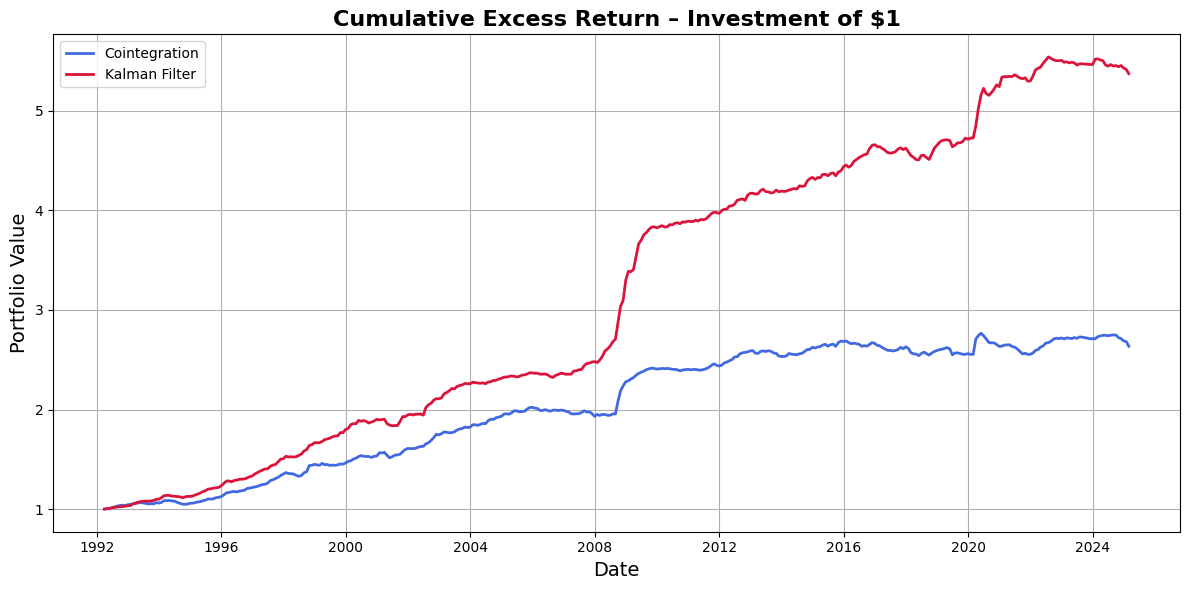

In [57]:

# Ensure datetime index
daily_returns_coint.index = pd.to_datetime(daily_returns_coint.index)
daily_returns_kalm.index = pd.to_datetime(daily_returns_kalm.index)

# Resample daily returns to monthly returns (summed and then adjusted)
monthly_returns_coint = daily_returns_coint.resample("1ME").sum() / 20
monthly_excess_coint = monthly_returns_coint / 6  # 6 portfolios

monthly_returns_kalm = daily_returns_kalm.resample("1ME").sum() / 20
monthly_excess_kalm = monthly_returns_kalm / 6  # 6 portfolios

# Compute cumulative returns from $1 investment
cumulative_coint = np.cumprod(1 + monthly_excess_coint)
cumulative_kalm = np.cumprod(1 + monthly_excess_kalm)

# Plot comparison
plt.figure(figsize=(12, 6))
plt.plot(cumulative_coint, label="Cointegration", color="royalblue", linewidth=2)
plt.plot(cumulative_kalm, label="Kalman Filter", color="crimson", linewidth=2)
plt.title("Cumulative Excess Return – Investment of $1", fontsize=16, fontweight="bold")
plt.xlabel("Date", fontsize=14)
plt.ylabel("Portfolio Value", fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

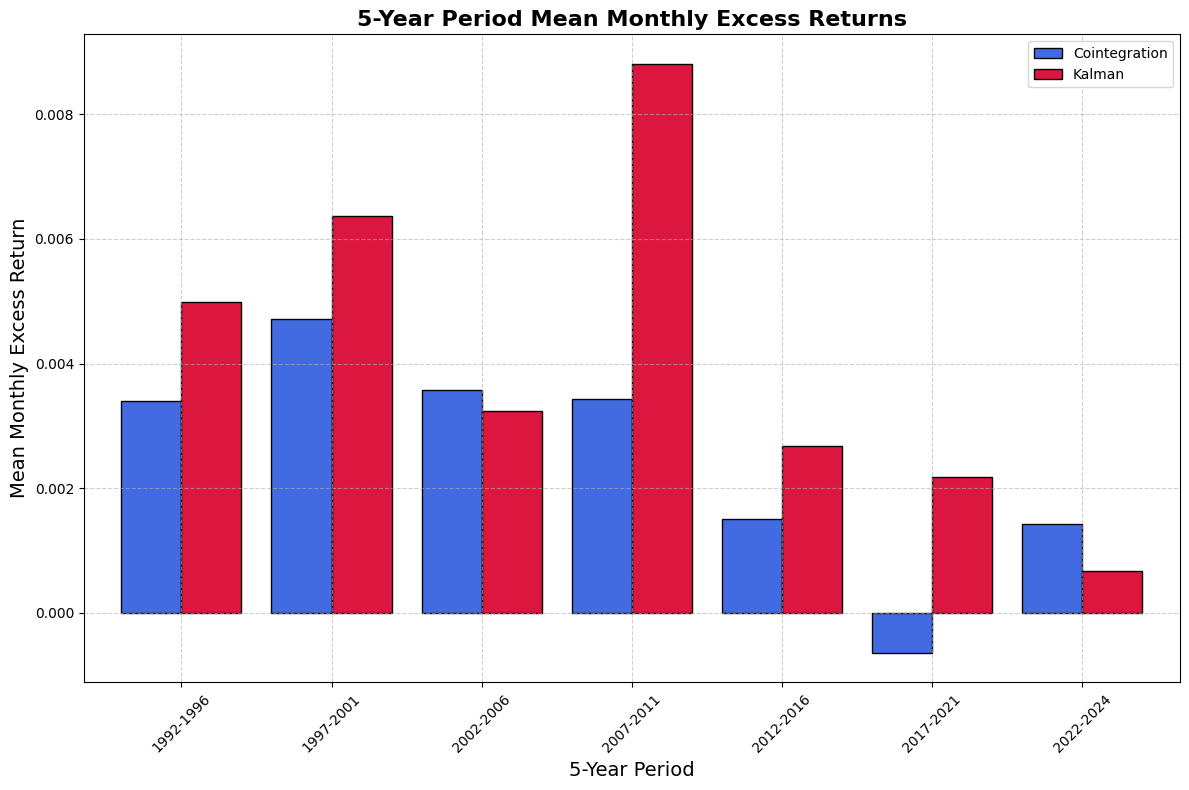

In [64]:

# Filter data to be before 2025-01-01
monthly_excess_coint = monthly_excess_coint[monthly_excess_coint.index <= "2025-01-01"] 
monthly_excess_kalm = monthly_excess_kalm[monthly_excess_kalm.index <= "2025-01-01"] 
monthly_excess_coint.index = pd.to_datetime(monthly_returns_coint.index)
monthly_excess_kalm.index = pd.to_datetime(monthly_returns_kalm.index)

# Define custom 5-year labels
def five_year_label(period):
    start = ((period.year - 1992) // 5) * 5 + 1992
    end = start + 4
    if end >= 2024:
        end = 2024
    return f"{start}-{end}"

# Apply labels
labels_coint = monthly_excess_coint.index.map(five_year_label)
labels_kalm = monthly_excess_kalm.index.map(five_year_label)

# Calculate 5-year mean excess returns (already divided by 6 portfolios earlier)
grouped_coint = (monthly_excess_coint).groupby(labels_coint).mean()
grouped_kalm = (monthly_excess_kalm).groupby(labels_kalm).mean()

# Combine into a DataFrame for side-by-side bars
df_compare = pd.concat([grouped_coint, grouped_kalm], axis=1)
df_compare.columns = ['Cointegration', 'Kalman']

# Plot side-by-side bars
ax = df_compare.plot(kind='bar', figsize=(12, 8), width=0.8,
                     color=['royalblue', 'crimson'], edgecolor='black', alpha=0.99)

plt.title("5-Year Period Mean Monthly Excess Returns", fontsize=16, fontweight="bold")
plt.xlabel("5-Year Period", fontsize=14)
plt.ylabel("Mean Monthly Excess Return", fontsize=14)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

- This plot shows how the strategy performed throughout the years, note that turbulent years seem to be good for the strategy 

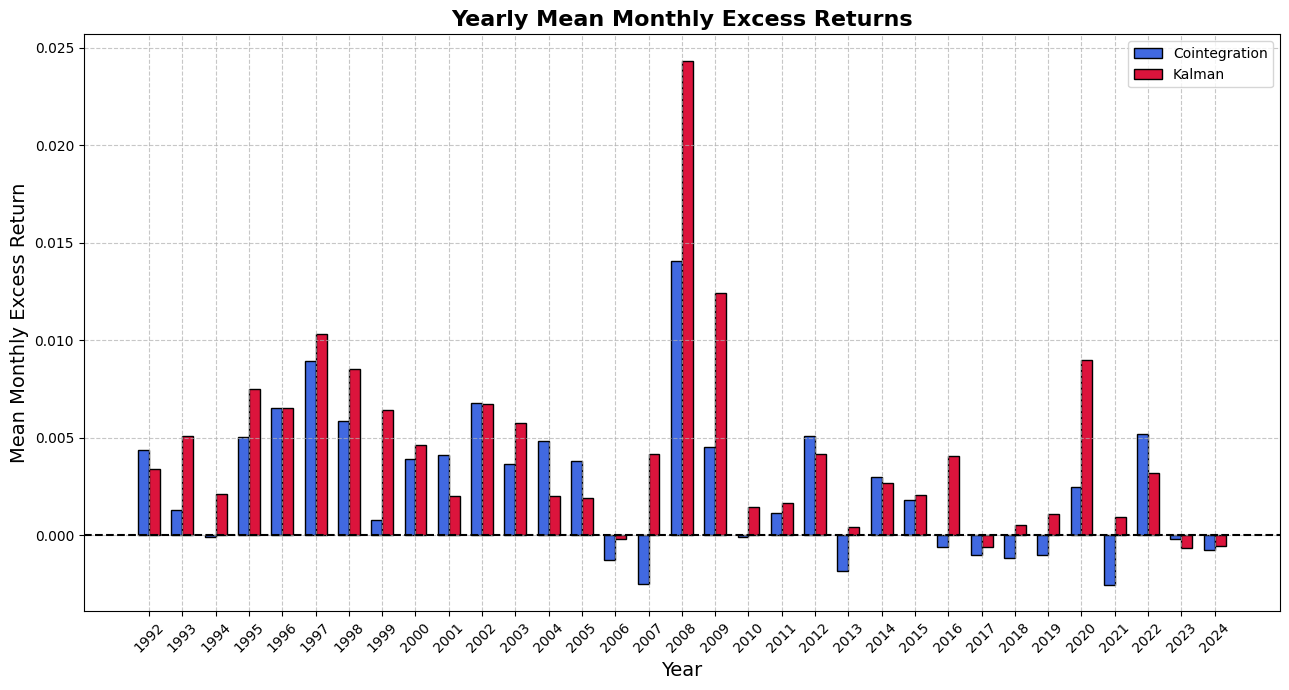

In [60]:

# Filter data to be before 2025-01-01
monthly_excess_coint = monthly_excess_coint[monthly_excess_coint.index <= "2025-01-01"] 
monthly_excess_kalm = monthly_excess_kalm[monthly_excess_kalm.index <= "2025-01-01"] 

# Resample to yearly frequency (mean of monthly excess returns)
yearly_coint = monthly_excess_coint.resample("1YE").mean()
yearly_kalm = monthly_excess_kalm.resample("1YE").mean()

# Align the two series
combined = pd.concat([yearly_coint, yearly_kalm], axis=1)
combined.columns = ['Cointegration', 'Kalman']
combined.dropna(inplace=True)

# Plot side-by-side bars for each year
fig, ax = plt.subplots(figsize=(13, 7))
bar_width =60  # Half-width of each bar (since we're using datetime x-axis)

# Create x positions
x = combined.index

# Plot bars
ax.bar(x - pd.Timedelta(days=bar_width), combined['Cointegration'].values,
       width= 2 * bar_width, label='Cointegration', color='royalblue', edgecolor='black')
ax.bar(x + pd.Timedelta(days=bar_width), combined['Kalman'].values,
       width=2 * bar_width, label='Kalman', color='crimson', edgecolor='black')

# Labels and grid
ax.axhline(0, color='black', linestyle='--')
ax.set_xlabel("Year", fontsize=14)
ax.set_ylabel("Mean Monthly Excess Return", fontsize=14)
ax.set_title("Yearly Mean Monthly Excess Returns", fontsize=16, fontweight="bold")
ax.grid(True, linestyle='--', alpha=0.7)

# Format x-axis ticks
ax.set_xticks(combined.index)
ax.set_xticklabels([d.year for d in combined.index], rotation=45)

# Add legend
ax.legend()
plt.tight_layout()
plt.show()

## Normal vs crisis period
- based on lowest quintile years of the SP&500 returns 

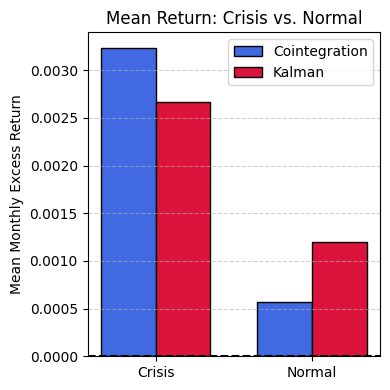

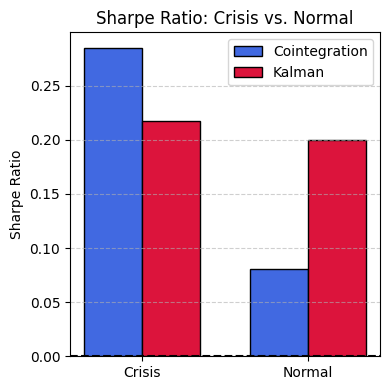

In [83]:
# Preprocess SP500 returns
sp500_returns = pd.read_csv("./sp-500-historical-annual-returns.csv", index_col=0)
sp500_returns.index = pd.to_datetime(sp500_returns.index)
sp500_returns = sp500_returns[(sp500_returns.index.year >= 1992) & (sp500_returns.index.year < 2025)] / 100
sp500_returns = sp500_returns.sort_values(by="value", ascending=True)

# Define crisis and normal years
threshold = sp500_returns['value'].quantile(0.2)  # Bottom 20% = crisis
crisis_years = sp500_returns[sp500_returns['value'] <= threshold].index.year
normal_years = sp500_returns[sp500_returns['value'] > threshold].index.year

# Define monthly excess returns
monthly_excess_coint = monthly_excess_coint[monthly_excess_coint.index <= "2025-01-01"] 
monthly_excess_kalm = monthly_excess_kalm[monthly_excess_kalm.index <= "2025-01-01"] 

# Separate into crisis and normal months
crisis_coint = monthly_excess_coint[monthly_excess_coint.index.year.isin(crisis_years)]
normal_coint = monthly_excess_coint[monthly_excess_coint.index.year.isin(normal_years)]

crisis_kalm = monthly_excess_kalm[monthly_excess_kalm.index.year.isin(crisis_years)]
normal_kalm = monthly_excess_kalm[monthly_excess_kalm.index.year.isin(normal_years)]

# Calculate mean returns and Sharpe ratios
means = [crisis_coint.mean(), normal_coint.mean(), crisis_kalm.mean(), normal_kalm.mean()]

sharpes = [
    crisis_coint.mean() / crisis_coint.std(),
    normal_coint.mean() / normal_coint.std(),
    crisis_kalm.mean() / crisis_kalm.std(),
    normal_kalm.mean() / normal_kalm.std()
]

# Bar labels and positions
labels = ['Crisis', 'Normal']
x = np.arange(len(labels))
width = 0.35

# Plot 1: Mean Returns
fig, ax = plt.subplots(figsize=(4, 4))
ax.bar(x - width/2, means[:2], width, label='Cointegration', color='royalblue', edgecolor='black')
ax.bar(x + width/2, means[2:], width, label='Kalman', color='crimson', edgecolor='black')
ax.axhline(0, color='black', linestyle='--')
ax.set_ylabel("Mean Monthly Excess Return")
ax.set_title("Mean Return: Crisis vs. Normal")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Plot 2: Sharpe Ratios
fig, ax = plt.subplots(figsize=(4, 4))
ax.bar(x - width/2, sharpes[:2], width, label='Cointegration', color='royalblue', edgecolor='black')
ax.bar(x + width/2, sharpes[2:], width, label='Kalman', color='crimson', edgecolor='black')
ax.axhline(0, color='black', linestyle='--')
ax.set_ylabel("Sharpe Ratio")
ax.set_title("Sharpe Ratio: Crisis vs. Normal")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



# After Costs 

## Trade Counts 
- They come from simultaneously monitoring 6 portfolios of 20 pairs 

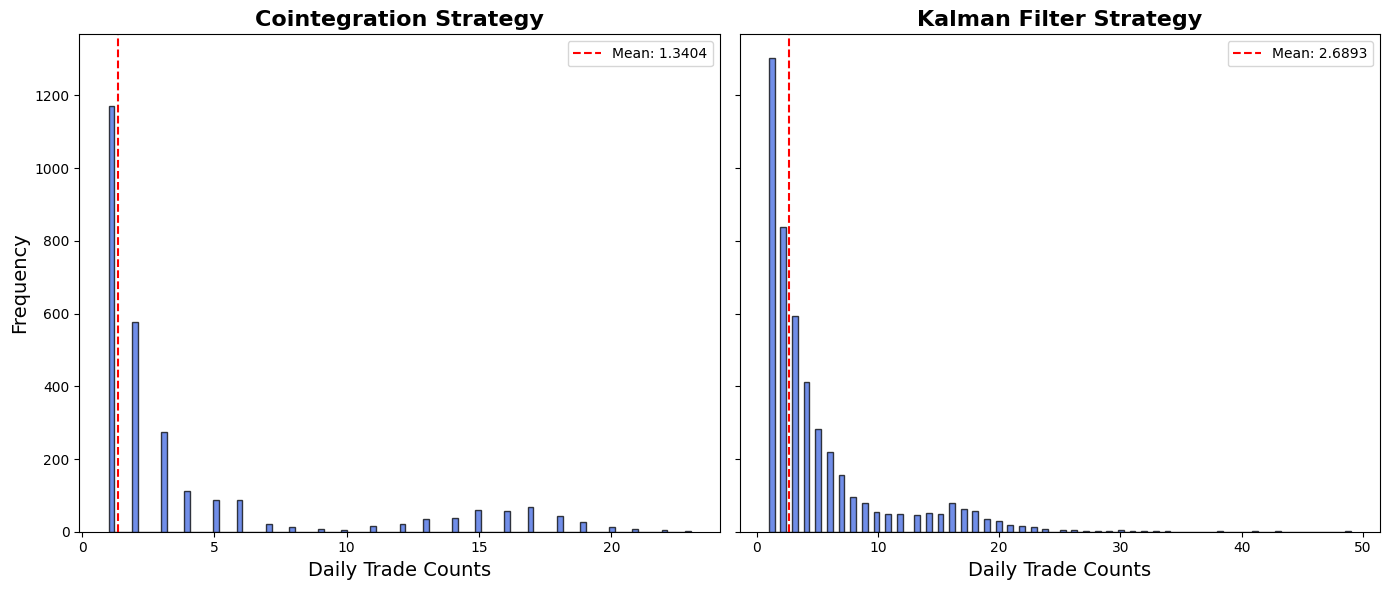

11137.0
22345.0


In [ ]:
trade_count_coint = pd.read_csv("./results/backtest_cointegration_tradecount_nocost.csv", index_col=0)
trade_count_coint.index = pd.to_datetime(trade_count_coint.index)
daily_count_coint = pd.DataFrame(trade_count_coint).sum(axis=1)
daily_count_hist_coint = daily_count_coint[daily_count_coint != 0]

trade_count_kalm = pd.read_csv("./results/backtest_kalman_tradecount_nocost.csv", index_col=0)
trade_count_kalm.index = pd.to_datetime(trade_count_kalm.index)
daily_count_kalm = pd.DataFrame(trade_count_kalm).sum(axis=1)
daily_count_hist_kalm = daily_count_kalm[daily_count_kalm != 0]

# Plot side-by-side histograms
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Cointegration histogram
axes[0].hist(daily_count_hist_coint, bins=100, color="royalblue", edgecolor="black", alpha=0.75)
axes[0].axvline(daily_count_coint.mean(), color='red', linestyle='dashed', linewidth=1.5,
                label=f"Mean: {daily_count_coint.mean():.4f}")
axes[0].set_title("Cointegration Strategy", fontsize=16, fontweight="bold")
axes[0].set_xlabel("Daily Trade Counts", fontsize=14)
axes[0].set_ylabel("Frequency", fontsize=14)
axes[0].legend()

# Kalman histogram
axes[1].hist(daily_count_hist_kalm, bins=100, color="royalblue", edgecolor="black", alpha=0.75)
axes[1].axvline(daily_count_kalm.mean(), color='red', linestyle='dashed', linewidth=1.5,
                label=f"Mean: {daily_count_kalm.mean():.4f}")
axes[1].set_title("Kalman Filter Strategy", fontsize=16, fontweight="bold")
axes[1].set_xlabel("Daily Trade Counts", fontsize=14)
axes[1].legend()

plt.tight_layout()
plt.show()
print(sum(daily_count_coint))
print(sum(daily_count_kalm))

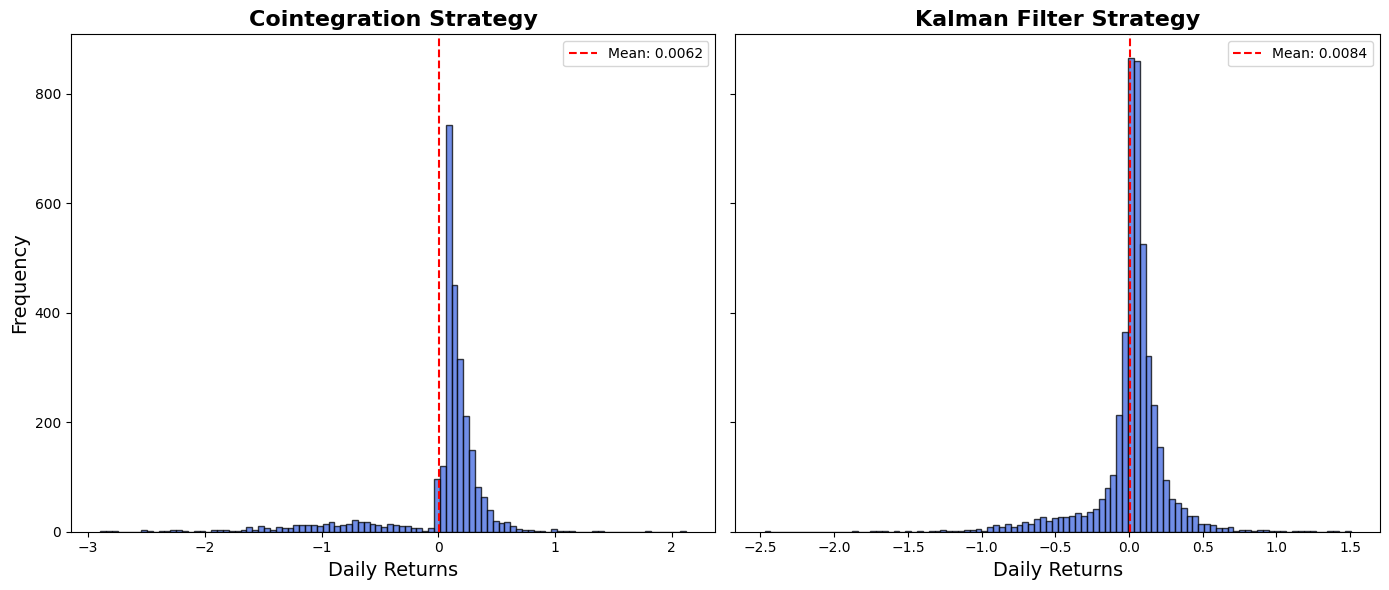

In [74]:
# Load cointegration strategy returns
backtest_cointegration_returns = pd.read_csv("./results/backtest_cointegration_returns_nocost.csv", index_col=0)
trade_count_coint = pd.read_csv("./results/backtest_cointegration_tradecount_nocost.csv", index_col=0)
trade_count_coint.index = pd.to_datetime(trade_count_coint.index)
backtest_cointegration_returns.index = pd.to_datetime(backtest_cointegration_returns.index)

# AFTER COSTS 
backtest_cointegration_returns_after_cost = backtest_cointegration_returns - trade_count_coint * 0.006
daily_returns_coint = pd.DataFrame(backtest_cointegration_returns_after_cost).sum(axis=1)
daily_returns_hist_coint = daily_returns_coint[daily_returns_coint != 0]

# Load Kalman strategy returns
backtest_kalman_returns = pd.read_csv("./results/backtest_kalman_returns_nocost.csv", index_col=0)
trade_count_kalm = pd.read_csv("./results/backtest_kalman_tradecount_nocost.csv", index_col=0)
trade_count_kalm.index = pd.to_datetime(trade_count_kalm.index)
backtest_kalman_returns.index = pd.to_datetime(backtest_kalman_returns.index)

# AFTER COSTS 
backtest_kalman_returns_after_cost = backtest_kalman_returns - trade_count_kalm * 0.006
daily_returns_kalm = pd.DataFrame(backtest_kalman_returns_after_cost).sum(axis=1)
daily_returns_hist_kalm = daily_returns_kalm[daily_returns_kalm != 0]

# Plot side-by-side histograms
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Cointegration histogram
axes[0].hist(daily_returns_hist_coint, bins=100, color="royalblue", edgecolor="black", alpha=0.75)
axes[0].axvline(daily_returns_coint.mean(), color='red', linestyle='dashed', linewidth=1.5,
                label=f"Mean: {daily_returns_coint.mean():.4f}")
axes[0].set_title("Cointegration Strategy", fontsize=16, fontweight="bold")
axes[0].set_xlabel("Daily Returns", fontsize=14)
axes[0].set_ylabel("Frequency", fontsize=14)
axes[0].legend()

# Kalman histogram
axes[1].hist(daily_returns_hist_kalm, bins=100, color="royalblue", edgecolor="black", alpha=0.75)
axes[1].axvline(daily_returns_kalm.mean(), color='red', linestyle='dashed', linewidth=1.5,
                label=f"Mean: {daily_returns_kalm.mean():.4f}")
axes[1].set_title("Kalman Filter Strategy", fontsize=16, fontweight="bold")
axes[1].set_xlabel("Daily Returns", fontsize=14)
axes[1].legend()

plt.tight_layout()
plt.show()

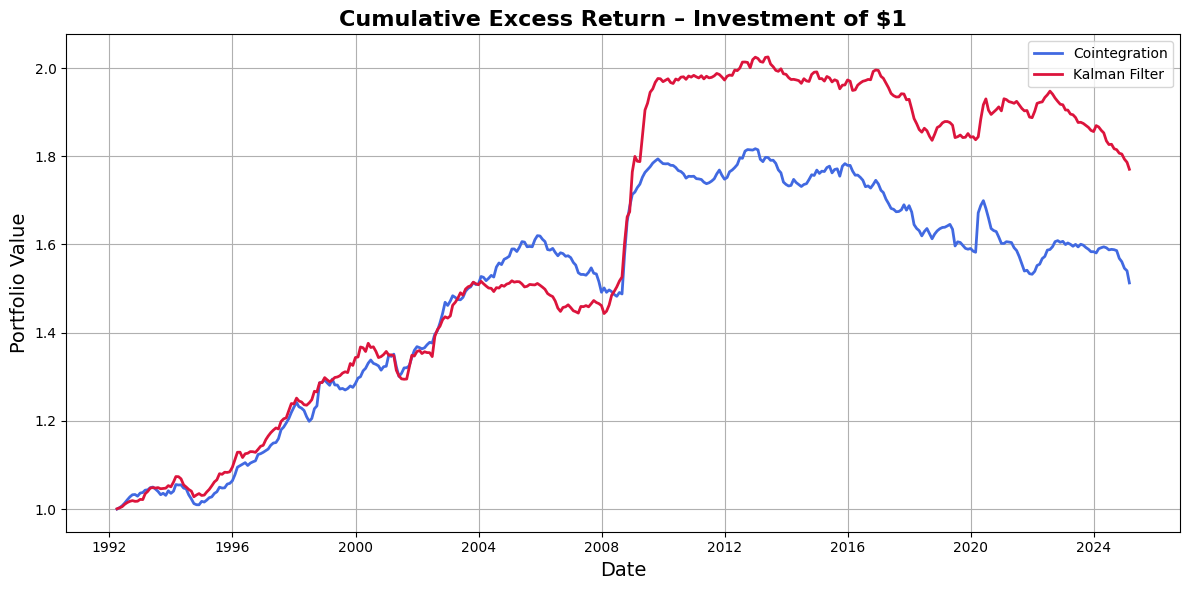

In [75]:
# Ensure datetime index
daily_returns_coint.index = pd.to_datetime(daily_returns_coint.index)
daily_returns_kalm.index = pd.to_datetime(daily_returns_kalm.index)

# Resample daily returns to monthly returns (summed and then adjusted)
monthly_returns_coint = daily_returns_coint.resample("1ME").sum() / 20
monthly_excess_coint = monthly_returns_coint / 6  # 6 portfolios

monthly_returns_kalm = daily_returns_kalm.resample("1ME").sum() / 20
monthly_excess_kalm = monthly_returns_kalm / 6  # 6 portfolios

# Compute cumulative returns from $1 investment
cumulative_coint = np.cumprod(1 + monthly_excess_coint)
cumulative_kalm = np.cumprod(1 + monthly_excess_kalm)

# Plot comparison
plt.figure(figsize=(12, 6))
plt.plot(cumulative_coint, label="Cointegration", color="royalblue", linewidth=2)
plt.plot(cumulative_kalm, label="Kalman Filter", color="crimson", linewidth=2)
plt.title("Cumulative Excess Return – Investment of $1", fontsize=16, fontweight="bold")
plt.xlabel("Date", fontsize=14)
plt.ylabel("Portfolio Value", fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

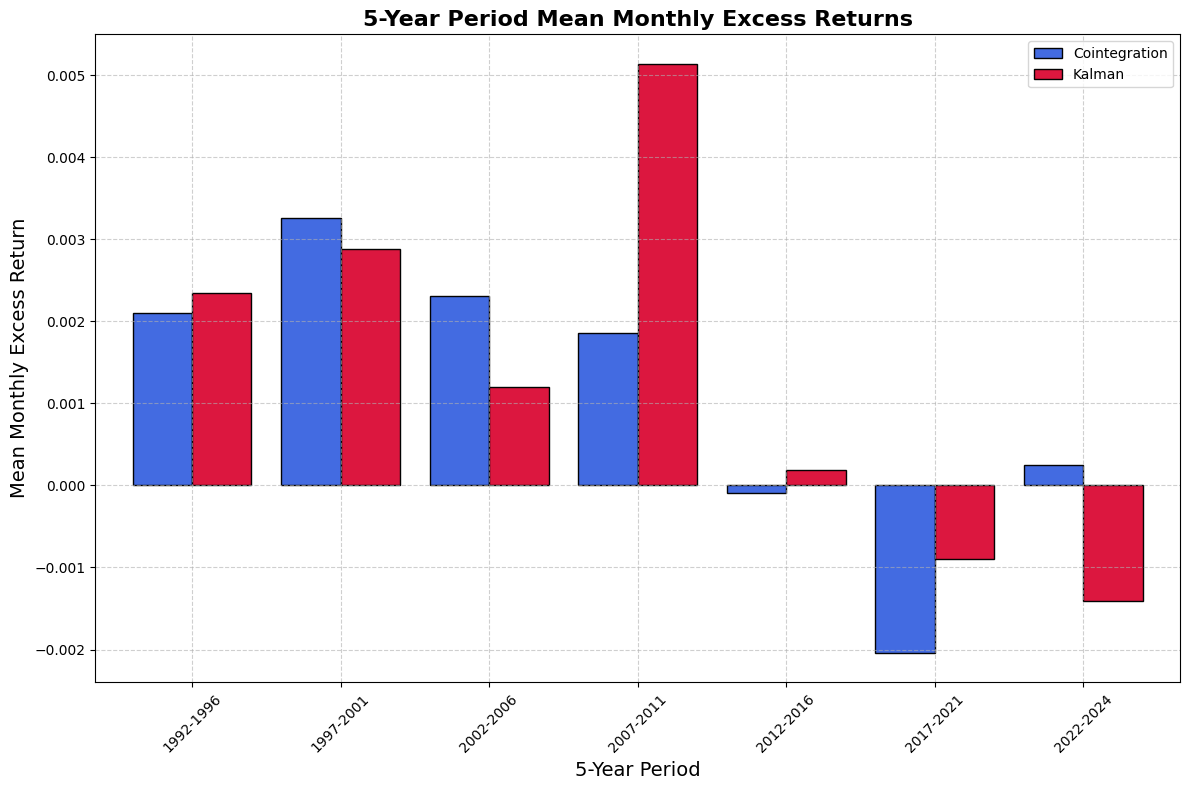

In [79]:
# Filter data to be before 2025-01-01
monthly_excess_coint = monthly_excess_coint[monthly_excess_coint.index <= "2025-01-01"] 
monthly_excess_kalm = monthly_excess_kalm[monthly_excess_kalm.index <= "2025-01-01"] 
monthly_excess_coint.index = pd.to_datetime(monthly_excess_coint.index)
monthly_excess_kalm.index = pd.to_datetime(monthly_excess_kalm.index)

# Define custom 5-year labels
def five_year_label(period):
    start = ((period.year - 1992) // 5) * 5 + 1992
    end = start + 4
    if end >= 2024:
        end = 2024
    return f"{start}-{end}"

# Apply labels
labels_coint = monthly_excess_coint.index.map(five_year_label)
labels_kalm = monthly_excess_kalm.index.map(five_year_label)

# Calculate 5-year mean excess returns (already divided by 6 portfolios earlier)
grouped_coint = (monthly_excess_coint).groupby(labels_coint).mean()
grouped_kalm = (monthly_excess_kalm).groupby(labels_kalm).mean()

# Combine into a DataFrame for side-by-side bars
df_compare = pd.concat([grouped_coint, grouped_kalm], axis=1)
df_compare.columns = ['Cointegration', 'Kalman']

# Plot side-by-side bars
ax = df_compare.plot(kind='bar', figsize=(12, 8), width=0.8,
                     color=['royalblue', 'crimson'], edgecolor='black', alpha=0.99)

plt.title("5-Year Period Mean Monthly Excess Returns", fontsize=16, fontweight="bold")
plt.xlabel("5-Year Period", fontsize=14)
plt.ylabel("Mean Monthly Excess Return", fontsize=14)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

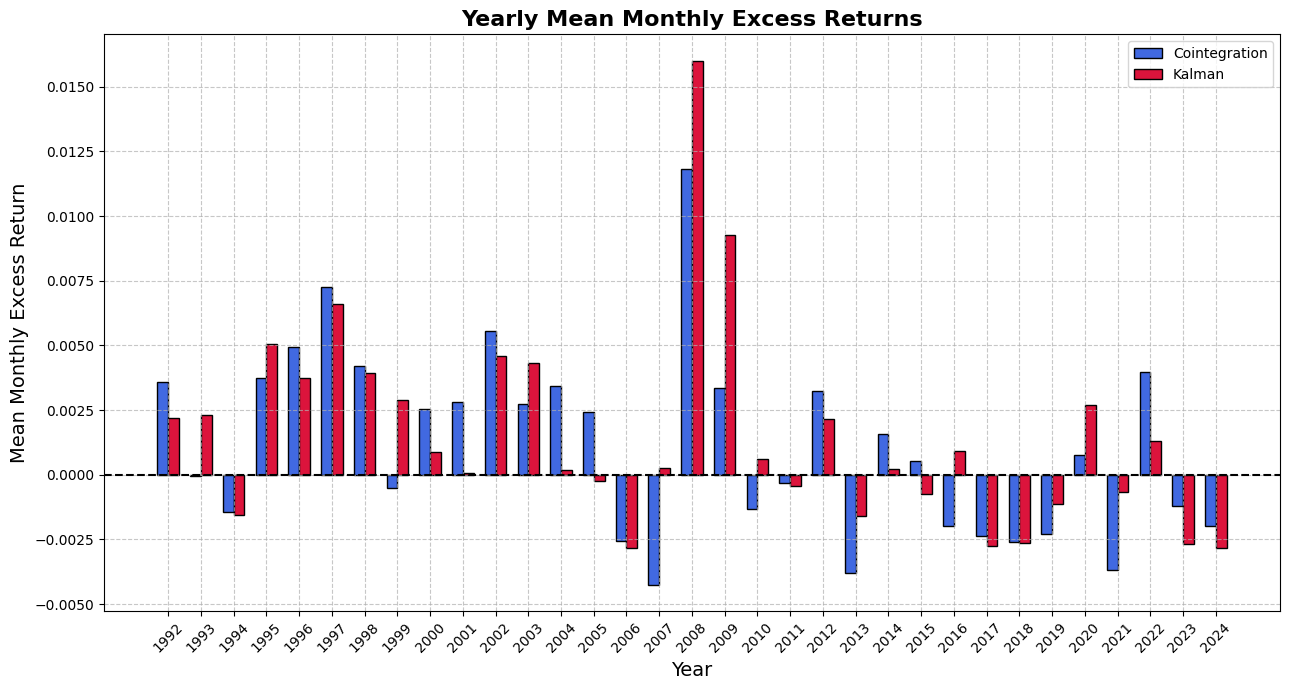

In [78]:

# Filter data to be before 2025-01-01
monthly_excess_coint = monthly_excess_coint[monthly_excess_coint.index <= "2025-01-01"] 
monthly_excess_kalm = monthly_excess_kalm[monthly_excess_kalm.index <= "2025-01-01"] 

# Resample to yearly frequency (mean of monthly excess returns)
yearly_coint = monthly_excess_coint.resample("1YE").mean()
yearly_kalm = monthly_excess_kalm.resample("1YE").mean()

# Align the two series
combined = pd.concat([yearly_coint, yearly_kalm], axis=1)
combined.columns = ['Cointegration', 'Kalman']
combined.dropna(inplace=True)

# Plot side-by-side bars for each year
fig, ax = plt.subplots(figsize=(13, 7))
bar_width =60  # Half-width of each bar (since we're using datetime x-axis)

# Create x positions
x = combined.index

# Plot bars
ax.bar(x - pd.Timedelta(days=bar_width), combined['Cointegration'].values,
       width= 2 * bar_width, label='Cointegration', color='royalblue', edgecolor='black')
ax.bar(x + pd.Timedelta(days=bar_width), combined['Kalman'].values,
       width=2 * bar_width, label='Kalman', color='crimson', edgecolor='black')

# Labels and grid
ax.axhline(0, color='black', linestyle='--')
ax.set_xlabel("Year", fontsize=14)
ax.set_ylabel("Mean Monthly Excess Return", fontsize=14)
ax.set_title("Yearly Mean Monthly Excess Returns", fontsize=16, fontweight="bold")
ax.grid(True, linestyle='--', alpha=0.7)

# Format x-axis ticks
ax.set_xticks(combined.index)
ax.set_xticklabels([d.year for d in combined.index], rotation=45)

# Add legend
ax.legend()
plt.tight_layout()
plt.show()

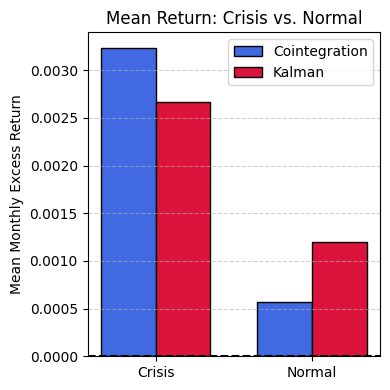

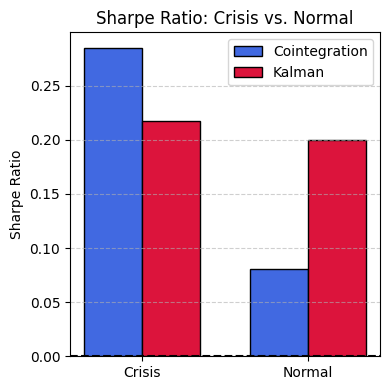

In [82]:
# Preprocess SP500 returns
sp500_returns = pd.read_csv("./sp-500-historical-annual-returns.csv", index_col=0)
sp500_returns.index = pd.to_datetime(sp500_returns.index)
sp500_returns = sp500_returns[(sp500_returns.index.year >= 1992) & (sp500_returns.index.year < 2025)] / 100
sp500_returns = sp500_returns.sort_values(by="value", ascending=True)

# Define crisis and normal years
threshold = sp500_returns['value'].quantile(0.2)  # Bottom 20% = crisis
crisis_years = sp500_returns[sp500_returns['value'] <= threshold].index.year
normal_years = sp500_returns[sp500_returns['value'] > threshold].index.year

# Define monthly excess returns
monthly_excess_coint = monthly_excess_coint[monthly_excess_coint.index <= "2025-01-01"] 
monthly_excess_kalm = monthly_excess_kalm[monthly_excess_kalm.index <= "2025-01-01"] 

# Separate into crisis and normal months
crisis_coint = monthly_excess_coint[monthly_excess_coint.index.year.isin(crisis_years)]
normal_coint = monthly_excess_coint[monthly_excess_coint.index.year.isin(normal_years)]

crisis_kalm = monthly_excess_kalm[monthly_excess_kalm.index.year.isin(crisis_years)]
normal_kalm = monthly_excess_kalm[monthly_excess_kalm.index.year.isin(normal_years)]

# Calculate mean returns and Sharpe ratios
means = [crisis_coint.mean(), normal_coint.mean(), crisis_kalm.mean(), normal_kalm.mean()]

sharpes = [
    crisis_coint.mean() / crisis_coint.std(),
    normal_coint.mean() / normal_coint.std(),
    crisis_kalm.mean() / crisis_kalm.std(),
    normal_kalm.mean() / normal_kalm.std()
]

# Bar labels and positions
labels = ['Crisis', 'Normal']
x = np.arange(len(labels))
width = 0.35

# Plot 1: Mean Returns
fig, ax = plt.subplots(figsize=(4, 4))
ax.bar(x - width/2, means[:2], width, label='Cointegration', color='royalblue', edgecolor='black')
ax.bar(x + width/2, means[2:], width, label='Kalman', color='crimson', edgecolor='black')
ax.axhline(0, color='black', linestyle='--')
ax.set_ylabel("Mean Monthly Excess Return")
ax.set_title("Mean Return: Crisis vs. Normal")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Plot 2: Sharpe Ratios
fig, ax = plt.subplots(figsize=(4, 4))
ax.bar(x - width/2, sharpes[:2], width, label='Cointegration', color='royalblue', edgecolor='black')
ax.bar(x + width/2, sharpes[2:], width, label='Kalman', color='crimson', edgecolor='black')
ax.axhline(0, color='black', linestyle='--')
ax.set_ylabel("Sharpe Ratio")
ax.set_title("Sharpe Ratio: Crisis vs. Normal")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
